### This is a project about detecting lane lines on different roads

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Firstly, we need to calibrate our camera!

In [3]:
# a simple demo showing how to find the chess corners of the checkboard picture

%matplotlib inline
filename="camera_cal/calibration2.jpg"
img=cv2.imread(filename)

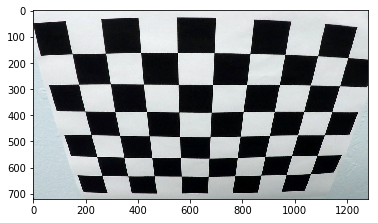

In [4]:
plt.imshow(img)

In [5]:
nx=9
ny=6
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

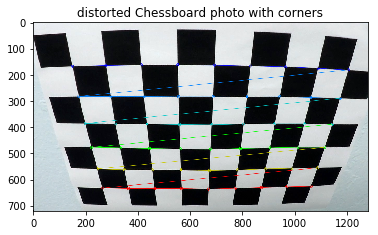

In [6]:
# draw chess corners on the picture:
if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("distorted Chessboard photo with corners")
    plt.show()

In [7]:
objp = np.zeros((nx*ny,3), np.float32)
objp.shape

(54, 3)

In [8]:
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

In [10]:
import glob
imagefiles=glob.glob('camera_cal/calibration*.jpg')

Firstly, I need to extract all the chess corners from imagefiles so that I can calibrate my cameras!

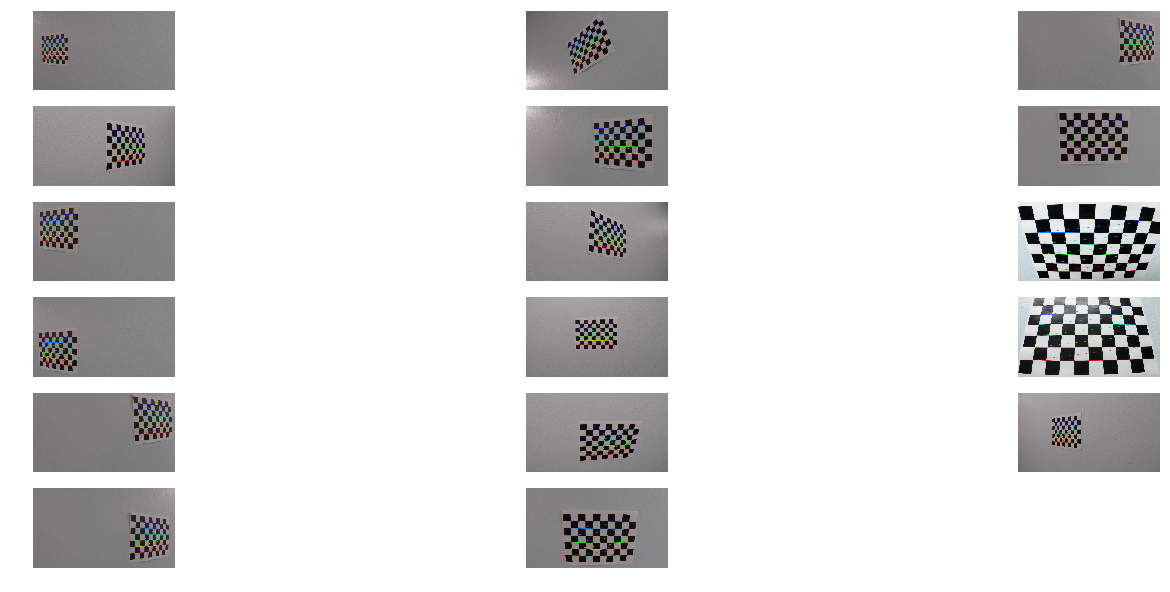

In [17]:
import pylab
pylab.rcParams['figure.figsize'] = (25, 12)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

count=1
for i in range(len(imagefiles)):
    image=cv2.imread(imagefiles[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.subplot(7,3,count)
        count+=1
        plt.axis('off')
        plt.imshow(image)
        #plt.show()
        

Then we need to create a undistort functions to undistort my functions

In [41]:
def undistort(image):
    img = mpimg.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

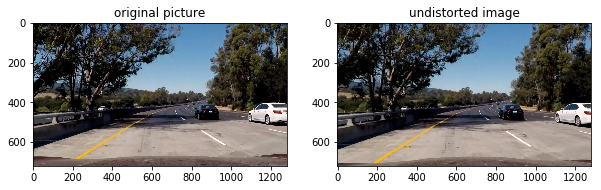

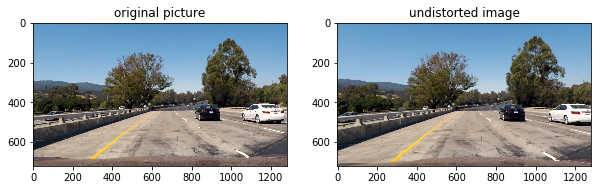

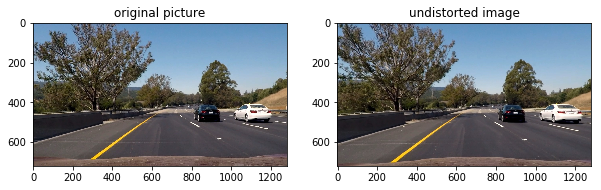

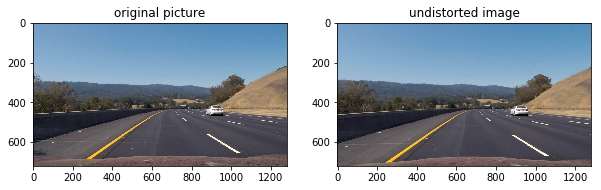

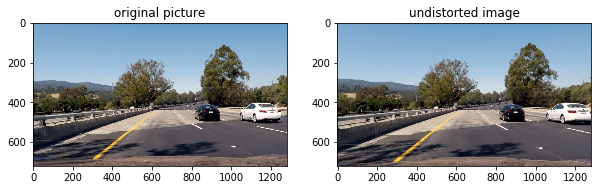

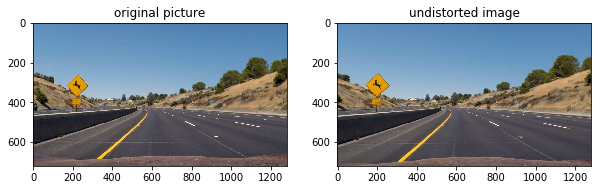

In [43]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    #image=cv2.imread(imagefile)
    undistortimage=undistort(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    originalimage=mpimg.imread(image)
    ax1.imshow(originalimage)
    ax1.set_title("original picture")
    ax2.imshow(undistortimage)
    ax2.set_title("undistorted image")

### Perspective Transform
Next, I need to transform the pictures above into a bird view so that I can compute the exact location of the lane lines

In [46]:
def unwarp(img):
    undist=undistort(img)
    img_size=(undist.shape[1],undist.shape[0])
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped,M

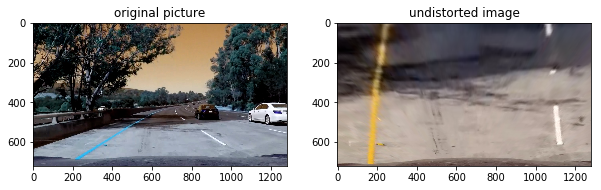

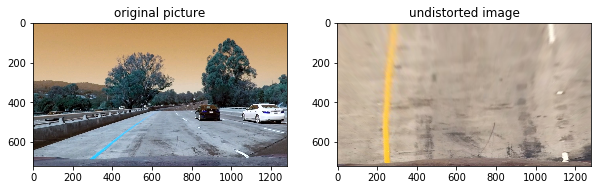

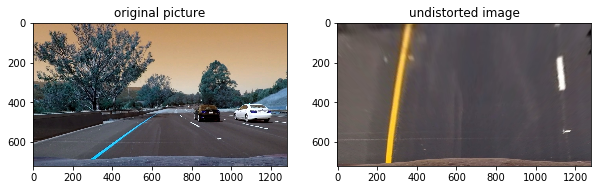

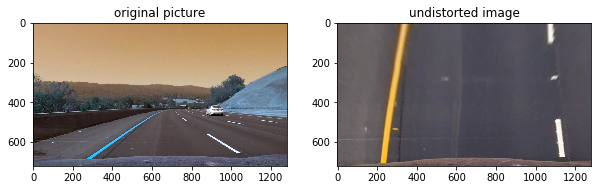

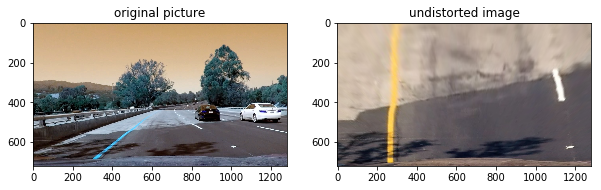

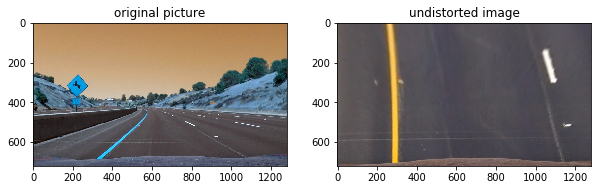

In [49]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    #image=cv2.imread(imagefile)
    unwarp_image,M=unwarp(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    originalimage=cv2.imread(image)
    ax1.imshow(originalimage)
    ax1.set_title("original picture")
    ax2.imshow(unwarp_image)
    ax2.set_title("undistorted image")


In [36]:
img1

array([[[ 47,  53,  75],
        [ 38,  44,  56],
        [ 33,  38,  41],
        ..., 
        [ 76,  94,  80],
        [102, 119, 103],
        [145, 159, 142]],

       [[ 40,  45,  64],
        [ 27,  34,  44],
        [ 19,  25,  23],
        ..., 
        [  9,  27,  15],
        [ 21,  38,  22],
        [ 90, 104,  89]],

       [[ 35,  41,  53],
        [ 23,  28,  32],
        [ 18,  23,  16],
        ..., 
        [ 19,  37,  25],
        [  7,  23,  10],
        [ 14,  28,  13]],

       ..., 
       [[ 31,  36,  40],
        [ 51,  50,  55],
        [ 97,  88,  91],
        ..., 
        [121, 106, 103],
        [121, 106, 103],
        [124, 109, 106]],

       [[ 42,  47,  51],
        [ 29,  30,  34],
        [ 66,  60,  64],
        ..., 
        [130, 115, 112],
        [131, 116, 113],
        [135, 120, 117]],

       [[ 47,  52,  58],
        [ 36,  37,  42],
        [ 37,  31,  35],
        ..., 
        [137, 122, 119],
        [138, 123, 120],
        [141, 126,

In [37]:
img2

array([[[ 75,  53,  47],
        [ 56,  44,  38],
        [ 41,  38,  33],
        ..., 
        [ 80,  94,  76],
        [103, 119, 102],
        [142, 159, 145]],

       [[ 64,  45,  40],
        [ 44,  34,  27],
        [ 23,  25,  19],
        ..., 
        [ 15,  27,   9],
        [ 22,  38,  21],
        [ 89, 104,  90]],

       [[ 53,  41,  35],
        [ 32,  28,  23],
        [ 16,  23,  18],
        ..., 
        [ 25,  37,  19],
        [ 10,  23,   7],
        [ 13,  28,  14]],

       ..., 
       [[ 40,  36,  31],
        [ 55,  50,  51],
        [ 91,  88,  97],
        ..., 
        [103, 106, 121],
        [103, 106, 121],
        [106, 109, 124]],

       [[ 51,  47,  42],
        [ 34,  30,  29],
        [ 64,  60,  66],
        ..., 
        [112, 115, 130],
        [113, 116, 131],
        [117, 120, 135]],

       [[ 58,  52,  47],
        [ 42,  37,  36],
        [ 35,  31,  37],
        ..., 
        [119, 122, 137],
        [120, 123, 138],
        [123, 126,